In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_geometric_temporal as tgt
import importlib
import pandas as pd
import FunctionCollection as fc
import pytorch_lightning as pl
import importlib
fc = importlib.reload(fc)

In [27]:
import Model_Loaders.Model_7 as M
M = importlib.reload(M)

In [36]:
args = {'N_edge_feats': 6,
        'N_dom_feats': 5,
        'N_targets': 1,
        'N_outputs': 1,
        'N_metalayers': 5,
        'N_hcs': 16,
        'diagonal_cov': True,
        'type': 'MSE+MAE',
        'eps': 0,
        'lr': 0.002}

Net = M.Load_model(args['type'],args)

Remember all accuracies are positive and defined to go towards 0 in the optimal case.


In [2]:
N_events = 100000
def E_target_constructor(dataset, transformer):
    E = dataset.data.y.view(N_events,-1,1)[:,0]
    dataset.data.y = torch.tensor(transformer['truth']['energy_log10'].inverse_transform(E),dtype=torch.float)
    dataset.slices['y'] = np.arange(0,len(dataset.data.y)+1, 1)
    return dataset

In [3]:
path = 'C:/Users/jv97/Desktop/github/Neutrino-Machine-Learning'
filename = 'muon_100k_set11_SRT.pt'#muon_100k_set11_SRT.pt #100k_muon_set21.pt
filepath = path + '/datasets'
transformer = pd.read_pickle(path+'/datasets/transformers.pkl')

dataset, train_loader, test_loader, val_loader = fc.dataset_preparator(name = filename,
                                                                       path = filepath,
                                                                       transformer = transformer,
                                                                       tc = E_target_constructor,
                                                                       fc = fc.dataset_feature_constructor,
                                                                       shuffle = True,
                                                                       TrTV_split = (0.9,0.9,1),
                                                                       batch_size = 512)

2021-03-09 16:49:40.510724: loading data..
2021-03-09 16:49:41.819824: executing target constructor..
2021-03-09 16:49:41.834991: executing feature constructor..
2021-03-09 16:49:51.160693: shuffling dataset..
2021-03-09 16:49:51.186696: defining dataloaders..
2021-03-09 16:49:51.187695: Done!


In [4]:
for data in train_loader:
    break

In [24]:
import time

In [23]:
@torch.jit.script
def time_edge_indeces(x,
                      batch: torch.Tensor):
    time_sort = torch.argsort(x[:,1])
    graph_ids, graph_node_counts = torch.unique(batch,return_counts=True)
    batch_time_sort = torch.cat( [time_sort[batch[time_sort] == i] for i in graph_ids] )
    time_edge_index = torch.cat([batch_time_sort[:-1].view(1,-1),batch_time_sort[1:].view(1,-1)],dim=0)

    tmp_ind = (torch.cumsum(graph_node_counts,0) - 1)[:-1]
    li : List[int] = (tmp_ind + 1).tolist()
    time_edge_index[1,tmp_ind] = time_edge_index[0, [0] + li[:-1]]
    time_edge_index = torch.cat([time_edge_index, 
                                 torch.cat([time_edge_index[1,-1].view(1,1),
                                            time_edge_index[0,(tmp_ind + 1)[-1]].view(1,1)])],dim=1)

    time_edge_index = time_edge_index[:,torch.argsort(time_edge_index[1])]
    return time_edge_index

In [26]:
@torch.jit.script
def x_feature_constructor(x, graph_node_counts):
    tmp = []
    a : List[int] = graph_node_counts.tolist()
    for tmp_x in x.split(a):
        tmp_x = tmp_x.unsqueeze(1) - tmp_x
        cart = tmp_x[:,:,-3:]
            
        rho = torch.norm(cart, p=2, dim=-1).unsqueeze(2)
        rho_mask = rho.squeeze() != 0
        cart[rho_mask] = cart[rho_mask] / rho[rho_mask]
        tmp_x = torch.cat([cart,rho,tmp_x[:,:,:-3]],dim=2)

        tmp.append(torch.cat([tmp_x.mean(1),tmp_x.std(1),tmp_x.min(1)[0],tmp_x.max(1)[0]],dim=1))
    return torch.cat(tmp,0)

In [72]:
# @torch.jit.script
def edge_feature_constructor(x, edge_index):
    (frm, to) = edge_index
    pos = x[:,-3:]
    cart = pos[frm] - pos[to]
    
    rho = torch.norm(cart, p=2, dim=-1).view(-1, 1)
    rho_mask = rho.squeeze() != 0
    cart[rho_mask] = cart[rho_mask] / rho[rho_mask]
    
    #Time difference and charge ratio
    T_diff = x[to,1] - x[frm,1]
    Q_diff = x[to,0] - x[frm,0]
    
    edge_attr = torch.cat([cart.type_as(pos),rho,T_diff.view(-1,1),Q_diff.view(-1,1)], dim=1)
    
    return edge_attr

In [65]:
x, edge_index, batch = data.x, data.edge_index, data.batch
graph_ids, graph_node_counts = batch.unique(return_counts=True)

start = time.time()
tmp = x_feature_constructor(x,graph_node_counts)
print(time.time() - start)

start = time.time()
tmp = []
for tmp_x in x.split(graph_node_counts.tolist()):
    tmp_x = tmp_x.unsqueeze(1) - tmp_x
    cart = tmp_x[:,:,-3:]

    rho = torch.norm(cart, p=2, dim=-1).unsqueeze(2)
    rho_mask = rho.squeeze() != 0
    cart[rho_mask] = cart[rho_mask] / rho[rho_mask]
    tmp_x = torch.cat([cart,rho,tmp_x[:,:,:-3]],dim=2)

    tmp.append(torch.cat([tmp_x.mean(1),tmp_x.std(1),tmp_x.min(1)[0],tmp_x.max(1)[0]],dim=1))
print(time.time() - start)

0.6770131587982178
0.7623074054718018


In [69]:
start = time.time()
tmp = time_edge_indeces(x,batch)
print(time.time() - start)

start = time.time()
time_sort = torch.argsort(x[:,1])
graph_ids, graph_node_counts = batch.unique(return_counts=True)
batch_time_sort = torch.cat( [time_sort[batch[time_sort] == i] for i in graph_ids] )
time_edge_index = torch.cat([batch_time_sort[:-1].view(1,-1),batch_time_sort[1:].view(1,-1)],dim=0)

tmp_ind = (torch.cumsum(graph_node_counts,0) - 1)[:-1]
time_edge_index[1,tmp_ind] = time_edge_index[0, [0] + (tmp_ind + 1).tolist()[:-1]]
time_edge_index = torch.cat([time_edge_index, 
                             torch.cat([time_edge_index[1,-1].view(1,1),
                                        time_edge_index[0,(tmp_ind + 1)[-1]].view(1,1)])],dim=1)

time_edge_index = time_edge_index[:,torch.argsort(time_edge_index[1])]
print(time.time() - start)

0.0010018348693847656
0.10000038146972656


In [107]:
start = time.time()
tmp = edge_feature_constructor(x,time_edge_index)
print(time.time() - start)

0.007006645202636719


In [86]:
torch.cat(tmp,dim=0).shape

torch.Size([43, 20])

In [82]:
x.shape

torch.Size([43, 5])

In [48]:
d = tmp_x.unsqueeze(1) - tmp_x
d.shape

torch.Size([27, 27, 5])

In [69]:
a = torch.tensor([[1,0],[0,0],[0,1]],dtype=torch.float)
(a.unsqueeze(1) - a).std(1)

tensor([[0.5774, 0.5774],
        [0.5774, 0.5774],
        [0.5774, 0.5774]])

In [67]:
help(a.std)

Help on built-in function std:

std(...) method of torch.Tensor instance
    std(dim=None, unbiased=True, keepdim=False) -> Tensor
    
    See :func:`torch.std`



In [61]:
# from torch_scatter import scatter_sum, scatter_min, scatter_max
# scatter_min(d,)
d.min(1)[0]
d.mean(1)

tensor([[ 2.6619e-01, -1.8873e-01, -2.3720e-02, -6.4897e-01,  4.8961e-01],
        [-3.9555e-01,  5.0301e-01, -4.3729e-01,  6.2600e-01, -1.4875e-01],
        [ 1.5543e-02,  3.4481e-01, -4.3729e-01,  6.2600e-01, -7.8685e-02],
        [ 1.8696e-01,  3.7926e-01, -2.1435e-01,  5.3926e-01, -4.8585e-02],
        [-1.7671e-01,  5.8897e-01, -2.7720e-02,  6.8943e-01, -9.4285e-02],
        [ 7.8812e-01,  2.1809e-01, -2.7720e-02,  6.8943e-01, -8.5188e-04],
        [-7.9366e-01, -2.3479e-02, -1.6379e-01,  6.6900e-01, -1.1342e-01],
        [-7.9366e-01,  3.7222e-01, -2.5072e-01,  7.7473e-01, -7.0052e-02],
        [ 1.5543e-02, -6.2753e-02,  1.2478e-01, -2.5977e-01, -1.7118e-02],
        [-5.1746e-01, -2.4319e-01,  1.2478e-01, -2.5977e-01, -1.7118e-02],
        [ 8.9555e-01, -1.7057e-01,  1.2478e-01, -2.5977e-01,  3.9615e-02],
        [ 4.8254e-01, -2.3467e-01,  1.2478e-01, -2.5977e-01,  3.9615e-02],
        [ 1.5543e-02,  4.9511e-02, -2.8655e-01, -3.2510e-01,  5.4318e-01],
        [-7.9366e-01, -1.

In [53]:
d.sum(1)

tensor([[ 7.1870e+00, -5.0956e+00, -6.4043e-01, -1.7522e+01,  1.3220e+01],
        [-1.0680e+01,  1.3581e+01, -1.1807e+01,  1.6902e+01, -4.0163e+00],
        [ 4.1966e-01,  9.3097e+00, -1.1807e+01,  1.6902e+01, -2.1245e+00],
        [ 5.0480e+00,  1.0240e+01, -5.7875e+00,  1.4560e+01, -1.3118e+00],
        [-4.7710e+00,  1.5902e+01, -7.4843e-01,  1.8615e+01, -2.5457e+00],
        [ 2.1279e+01,  5.8885e+00, -7.4843e-01,  1.8615e+01, -2.3001e-02],
        [-2.1429e+01, -6.3394e-01, -4.4222e+00,  1.8063e+01, -3.0623e+00],
        [-2.1429e+01,  1.0050e+01, -6.7694e+00,  2.0918e+01, -1.8914e+00],
        [ 4.1966e-01, -1.6943e+00,  3.3691e+00, -7.0138e+00, -4.6220e-01],
        [-1.3972e+01, -6.5661e+00,  3.3691e+00, -7.0138e+00, -4.6220e-01],
        [ 2.4180e+01, -4.6054e+00,  3.3691e+00, -7.0138e+00,  1.0696e+00],
        [ 1.3028e+01, -6.3361e+00,  3.3691e+00, -7.0138e+00,  1.0696e+00],
        [ 4.1966e-01,  1.3368e+00, -7.7369e+00, -8.7778e+00,  1.4666e+01],
        [-2.1429e+01, -5.

In [27]:
x, edge_index, batch = data.x, data.edge_index, data.batch

# time_sort = torch.argsort(x[:,1])
# graph_ids, graph_node_counts = batch.unique(return_counts=True)
# batch_time_sort = torch.cat( [time_sort[batch[time_sort] == i] for i in graph_ids] )
# time_edge_index = torch.cat([batch_time_sort[:-1].view(1,-1),batch_time_sort[1:].view(1,-1)],dim=0)

# tmp_ind = (torch.cumsum(graph_node_counts,0) - 1)[:-1]

time_sort = torch.argsort(x[:,1])
graph_ids, graph_node_counts = batch.unique(return_counts=True)
batch_time_sort = torch.cat( [time_sort[batch[time_sort] == i] for i in graph_ids] )
time_edge_index = torch.cat([batch_time_sort[:-1].view(1,-1),batch_time_sort[1:].view(1,-1)],dim=0)

tmp_ind = (torch.cumsum(graph_node_counts,0) - 1)[:-1]
time_edge_index[1,tmp_ind] = time_edge_index[0, [0] + (tmp_ind + 1).tolist()[:-1]]
time_edge_index = torch.cat([time_edge_index, 
                             torch.cat([time_edge_index[1,-1].view(1,1),
                                        time_edge_index[0,(tmp_ind + 1)[-1]].view(1,1)])],dim=1)

time_edge_index = time_edge_index[:,torch.argsort(time_edge_index[1])]

In [29]:
graph_node_counts,time_edge_index, torch.cat([torch.arange(x.shape[0]).view(-1,1),x[:,1].view(-1,1)*10],dim=1)

(tensor([47, 14]),
 tensor([[19,  2,  3,  4,  7, 23, 17, 11, 38,  0, 21,  8, 25, 29, 12, 20,  1, 16,
          22,  6, 24, 18,  5,  9, 44, 26, 37, 45, 13, 15, 36, 32, 46, 14, 31, 40,
          34, 28, 33, 35, 42, 43, 41, 27, 30, 10, 39, 58, 50, 55, 52, 49, 53, 51,
          47, 59, 57, 60, 48, 56, 54],
         [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
          36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
          54, 55, 56, 57, 58, 59, 60]]),
 tensor([[ 0.0000e+00,  5.6132e+00],
         [ 1.0000e+00,  4.5313e+00],
         [ 2.0000e+00,  4.1089e+00],
         [ 3.0000e+00,  3.5235e+00],
         [ 4.0000e+00,  3.1975e+00],
         [ 5.0000e+00,  6.2171e+00],
         [ 6.0000e+00,  5.0019e+00],
         [ 7.0000e+00,  2.5491e+00],
         [ 8.0000e+00,  2.0007e+00],
         [ 9.0000e+00,  5.6132e+00],
         [ 1.0000e+01,  8.8033e+00],
  

In [30]:
edge_attr = fc.edge_feature_constructor(x, time_edge_index)

In [31]:
edge_attr.shape, x.shape

(torch.Size([61, 6]), torch.Size([61, 5]))

In [35]:
torch.cat([x,edge_attr,x[time_edge_index[0]]],dim=1).shape

torch.Size([61, 16])

In [12]:
# torch.cat([torch.arange(dat.x.shape[0]).view(1,-1),dat.batch.view(1,-1)],dim=0)
torch.empty((10,2))

tensor([[0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [2.6302e+20, 6.1943e-04],
        [7.2056e+22, 2.1720e+29],
        [1.8057e+28, 9.9016e-03],
        [4.3988e+21, 1.8524e+28],
        [2.4715e+20, 1.0395e+21],
        [2.5150e+32, 1.8465e+25],
        [2.4343e+02, 1.9283e+31]])

In [38]:
#src_minus_mean = (src - mean.gather(dim, index))
# dat.batch, dat
# dat.x[:,-3:]
# dat.x[:,0].gather(0,dat.batch).view(-1,1)
from torch_scatter import scatter_sum
scatter_sum(dat.x[:,-3:]*dat.x[:,0].view(-1,1),dat.batch,0)/scatter_sum(dat.x[:,0].view(-1,1),dat.batch,0)

tensor([[ 0.2686, -1.4483, -1.3319],
        [ 1.3573, -0.2679, -1.0197],
        [-1.1871,  0.3860, -0.2328],
        ...,
        [-0.0171, -0.0691, -0.5840],
        [-0.5183, -1.0159,  0.7733],
        [ 0.1657,  1.9409,  0.0758]])

In [37]:
model = Net()

In [51]:
(e[0] == e[1]).sum(), (dat.edge_index[0] == dat.edge_index[1]).sum()

(tensor(15203), tensor(15203))

In [52]:
dat

Batch(batch=[15203], edge_attr=[135835, 6], edge_index=[2, 135835], pos=[15203, 3], x=[15203, 5], y=[512, 1])

In [40]:
u, counts = torch.unique(e[0,e[0] == e[1]],return_counts = True)
torch.unique(counts)

tensor([1])

In [70]:
e, dat.edge_index[:,torch.argsort(dat.edge_index[1,torch.argsort(dat.edge_index[0])])]

(tensor([[    1,     2,     3,  ..., 15200, 15201, 15202],
         [    0,     0,     0,  ..., 15200, 15201, 15202]]),
 tensor([[    0,     0,     0,  ..., 15200, 15201, 15202],
         [    0,     3,     6,  ..., 15194, 15193, 15202]]))

In [77]:
e[:,:100], dat.edge_index[:,:100]

(tensor([[ 1,  2,  3,  4,  5,  6,  0,  2,  3,  4,  5,  6,  0,  1,  3,  4,  5,  6,
           7,  8,  0,  1,  2,  4,  5,  6,  7,  8,  0,  1,  2,  3,  5,  6,  7,  8,
           0,  1,  2,  3,  4,  7,  8,  0,  1,  2,  3,  4,  7,  8,  2,  3,  4,  5,
           6,  8,  2,  3,  4,  5,  6,  7, 10, 11, 12, 13, 14, 15,  9, 11, 12, 13,
          14, 15,  9, 10, 12, 13, 14, 15,  9, 10, 11, 13, 14, 15,  9, 10, 11, 12,
          14, 15,  9, 10, 11, 12, 13, 15,  9, 10],
         [ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
           2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,
           5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,
           7,  7,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10,
          10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13,
          13, 13, 14, 14, 14, 14, 14, 14, 15, 15]]),
 tensor([[ 0,  1,  2,  3,  4,  5,  6,  0,  1,  2,  3,  4,  5,  6,  0,  1,  2

In [107]:
(x[1] != dat.edge_index).sum() == 0

tensor(True)

In [105]:
x = model(dat)

In [40]:
trainer =  pl.Trainer(gpus=-1, #-1 for all gpus
                      min_epochs=1,
                      max_epochs=20,
                      auto_lr_find = False,
#                       log_every_n_steps = 5,
                      terminate_on_nan = True,
#                       resume_from_checkpoint = path + '/checkpoints/' + 'TGCN_latest.ckpt',
                      logger = False,
                      default_root_dir = path)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [41]:
trainer.fit(model,train_loader,val_loader)


  | Name        | Type       | Params
-------------------------------------------
0 | act         | SiLU       | 0     
1 | x_encoder   | Linear     | 480   
2 | CoC_encoder | Linear     | 1.9 K 
3 | GRUCells    | ModuleList | 19.9 K
4 | lins1       | ModuleList | 32.4 K
5 | lins2       | ModuleList | 6.5 K 
6 | lins3       | ModuleList | 2.6 K 
7 | decoders    | ModuleList | 544   
8 | decoder     | Linear     | 17    
-------------------------------------------
64.4 K    Trainable params
0         Non-trainable params
64.4 K    Total params
0.258     Total estimated model params size (MB)


1

In [55]:
filename = 'muon_100k_set12_SRT.pt'

test_dataset, _, test_loader, _ = fc.dataset_preparator(name = filename,
                                                        path = filepath,
                                                        transformer = transformer,
                                                        tc = E_target_constructor,
                                                        fc = fc.custom_feature_constructor,
                                                        shuffle = True,
                                                        TrTV_split = (0,1,1),
                                                        batch_size = 512)

2021-02-25 20:34:47.410588: loading data..
2021-02-25 20:34:48.780944: executing target constructor..
2021-02-25 20:34:48.782944: executing feature constructor..
2021-02-25 20:34:58.048015: shuffling dataset..
2021-02-25 20:34:58.088001: defining dataloaders..
2021-02-25 20:34:58.089001: Done!


In [80]:
trainer.save_checkpoint(path + '/checkpoints/' + 'TGCN_latest.ckpt')

In [81]:
model = Net.load_from_checkpoint(path + '/checkpoints/' +'TGCN_latest.ckpt')

In [83]:
# pred = trainer.predict(model,test_loader)
# pred = np.row_stack(pred)
# truth = test_dataset.data.y.view(N_events,-1).numpy()

pred, truth = fc.return_reco_truth(model,test_loader)

Batch: 100%|█████████████████████████████████| 196/196 [01:58<00:00,  2.00it/s]

In [84]:
np.mean(np.abs(pred[:,0] - truth[:,0]))

0.1904278211927414

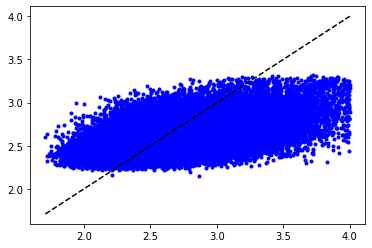

In [85]:
fig, ax = plt.subplots()

ax.plot(truth[:,0],pred[:,0],'b.')
ax.plot([truth.min(),truth.max()],[truth.min(),truth.max()],'k--')

In [86]:
2900/3500000

0.0008285714285714286